Todo (2023.01.22):
1. Compare multi phi theta's with single phi thetas
2. compare multi phi theta's with Ben Lehner's reported thetas
3. Compare shapes of multi phi model with single phi models
4. Implement multi-phi-GE regression (i.e. multi-GE measurement process will be needed) and compare performances
5. Plot phi_1 and phi_2 vs. measured binding values
6. Write this all up in report/packet and include single theta model results and brief summary of assays.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
binding_df_full = pd.read_csv('data/GRB2-SH3.binding.csv')
binding_df = binding_df_full[['aa_seq','count_e1_s0','count_e1_s1']].dropna().reset_index(drop=True).copy()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
abundance_df = pd.read_csv('data/GRB2-SH3.abundance.csv')
abundance_df = abundance_df[['aa_seq','count_e1_s0','count_e1_s1']].dropna().reset_index(drop=True).copy()

In [4]:
data_df = binding_df.copy()
y_cols = data_df.columns[1:] 

In [5]:
X = data_df['aa_seq']
y = data_df[y_cols]

In [6]:
# set positional argumnets for gpmap function
L = len(data_df['aa_seq'][0])
alphabet=['A', 'C', 'D', 'E', 'F',
          'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R',
          'S', 'T', 'V', 'W', 'Y', '*']


Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=57, Y=2


In [7]:
# gpmap_binding_DM = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)
# gpmap_binding_EE = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)

#gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)

#gpmap_blackbox = mavenn.gpmap.MultilayerPerceptronGPMap(L, alphabet)

# # instantiate gpmap object
gpmap = mavenn.gpmap.Multi_AdditiveGPMapLayer(L=L, 
                                              alphabet=alphabet,
                                              number_latent_nodes=2)



In [8]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [9]:
Y

2

In [10]:
mp_DM = mavenn.measurement_process_layers.MultiLatentDiscreteAgnosticMP(info_for_layers_dict={'H_y_norm':0},
                                                               Y=Y,
                                                               number_latent_nodes=2,
                                                               K=50,
                                                               eta=1e-5,)




In [11]:
model = mavenn.Model2(gpmap=gpmap,
                      mp_list=[mp_DM])

2023-01-26 08:04:42.184986: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
# Set training data
model.set_data(x=x_train.values,
               y_list=[y_train.values],
               shuffle=True)

N = 38,449 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 1.98 sec.


In [13]:
# # Set training data
# model.set_data(x=x_train.values,
#                y_list=[y_train.values],
#                shuffle=True)


### Note compare this model's shapes to discrete agnostic

In [14]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence_labels_input (InputLa  [(None, 1199)]      0           []                               
 yer)                                                                                             
                                                                                                  
 Sequence_only (Lambda)         (None, 1197)         0           ['Sequence_labels_input[0][0]']  
                                                                                                  
 multi__additive_gp_map_layer (  (None, 2)           2396        ['Sequence_only[0][0]']          
 Multi_AdditiveGPMapLayer)                                                                        
                                                                                              

In [15]:

# Fit model to data
model.fit(learning_rate=.0002,
                     epochs=100,
                     batch_size=400,
                     try_tqdm = False,
                     early_stopping=False,
                     verbose=True,
                     early_stopping_patience=10,
                     linear_initialization=False)


Epoch 1/100
77/77 [==============================] - 3s 11ms/step - loss: 112962.3047 - I_var: -0.5920 - val_loss: 92095.5391 - val_I_var: -0.1185
Epoch 2/100
77/77 [==============================] - 0s 6ms/step - loss: 70319.0078 - I_var: -0.0192 - val_loss: 80418.9453 - val_I_var: -4.6806e-04
Epoch 3/100
77/77 [==============================] - 1s 7ms/step - loss: 68331.4453 - I_var: -4.4719e-04 - val_loss: 80180.1016 - val_I_var: 0.0027
Epoch 4/100
77/77 [==============================] - 1s 7ms/step - loss: 68154.6875 - I_var: 0.0014 - val_loss: 79961.6641 - val_I_var: 0.0047
Epoch 5/100
77/77 [==============================] - 1s 7ms/step - loss: 68017.9219 - I_var: 0.0016 - val_loss: 79803.3438 - val_I_var: 0.0080
Epoch 6/100
77/77 [==============================] - 1s 7ms/step - loss: 68012.7578 - I_var: 0.0056 - val_loss: 79618.1328 - val_I_var: 0.0100
Epoch 7/100
77/77 [==============================] - 1s 7ms/step - loss: 67813.3359 - I_var: 0.0043 - val_loss: 79439.0703 - va

Epoch 58/100
77/77 [==============================] - 1s 7ms/step - loss: 59718.5508 - I_var: 0.1348 - val_loss: 70257.0312 - val_I_var: 0.1382
Epoch 59/100
77/77 [==============================] - 1s 7ms/step - loss: 59832.5977 - I_var: 0.1429 - val_loss: 70450.7656 - val_I_var: 0.1362
Epoch 60/100
77/77 [==============================] - 1s 7ms/step - loss: 59672.5547 - I_var: 0.1408 - val_loss: 70530.8672 - val_I_var: 0.1354
Epoch 61/100
77/77 [==============================] - 0s 6ms/step - loss: 59524.1602 - I_var: 0.1430 - val_loss: 70525.4062 - val_I_var: 0.1357
Epoch 62/100
77/77 [==============================] - 1s 7ms/step - loss: 59378.3320 - I_var: 0.1406 - val_loss: 70040.0391 - val_I_var: 0.1414
Epoch 63/100
77/77 [==============================] - 1s 6ms/step - loss: 59351.1172 - I_var: 0.1413 - val_loss: 70176.2734 - val_I_var: 0.1400
Epoch 64/100
77/77 [==============================] - 1s 7ms/step - loss: 59279.4414 - I_var: 0.1407 - val_loss: 70409.8906 - val_I_var:

On test data:


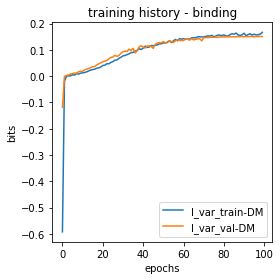

In [16]:
# Show training history
print('On test data:')
# x_test = test_df['x'].values
# y_test = test_df[y_cols].values


I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(figsize=[4,4])

ax.plot(I_var_hist, label='I_var_train-DM')
ax.plot(val_I_var_hist, label='I_var_val-DM')
#ax.set_xscale('log')
ax.set_title('training history - binding')

ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')

fig.tight_layout()
#fig.savefig('plots/GRB2_SH3/training_history_binding.png',dpi=200,bbox_inches='tight')


In [17]:
#phi = gpmap.x_to_phi(x_test)
theta_2_lc = np.squeeze(model.model.layers[2].get_weights()[1])

Text(0, 0.5, '$\\theta_{lc}, \\phi_2$ ')

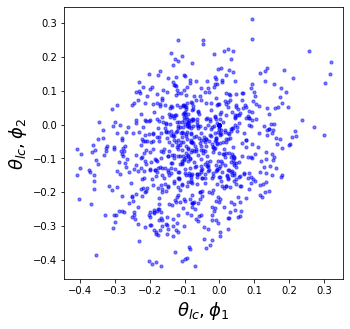

In [18]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(theta_2_lc[0],theta_2_lc[1],s=10,color='blue',alpha=0.5)
ax.set_xlabel('$\\theta_{lc}, \phi_1$ ',fontsize=18)
ax.set_ylabel('$\\theta_{lc}, \phi_2$ ',fontsize=18)

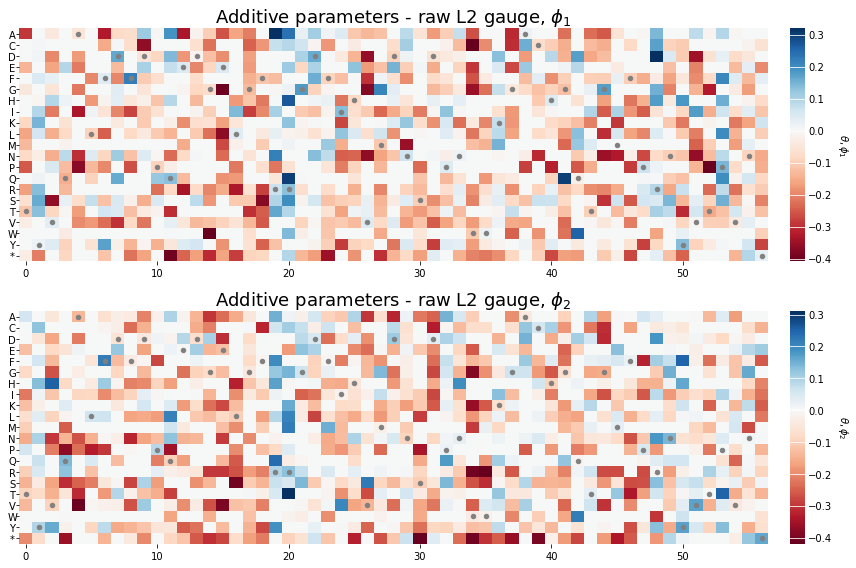

In [19]:

# # Create fig and ax objects
fig, axs = plt.subplots(2,1, figsize=[12,8])

ax = axs[0]
# Draw heatmap
ax, cb = mavenn.heatmap(ax=ax,
                        values=theta_2_lc[0],
                        alphabet=alphabet,
                        seq=model.x_stats['consensus_seq'],
                        seq_kwargs={'c':'gray', 's':20,'marker':'o'},
                        cmap='RdBu',
                        cbar=True,
                        #clim = [-5,1],
                        cmap_size='2%',
                        cmap_pad=.3,
                        ccenter=0)

# Style colorbar
cb.set_label('$\\theta, \phi_1$',
             labelpad=10, ha='center', va='center', rotation=-90)
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
ax.set_title('Additive parameters - raw L2 gauge, $\phi_1$',fontsize=18)

ax = axs[1]
# Draw heatmap
ax, cb = mavenn.heatmap(ax=ax,
                        values=theta_2_lc[1],
                        alphabet=alphabet,
                        seq=model.x_stats['consensus_seq'],
                        seq_kwargs={'c':'gray', 's':20,'marker':'o'},
                        cmap='RdBu',
                        cbar=True,
                        #clim = [-5,1],
                        cmap_size='2%',
                        cmap_pad=.3,
                        ccenter=0)

# Style colorbar
cb.set_label('$\\theta, \phi_2$',
             labelpad=10, ha='center', va='center', rotation=-90)
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
ax.set_title('Additive parameters - raw L2 gauge, $\phi_2$',fontsize=18)


fig.tight_layout()
#fig.savefig('plots/GRB2_SH3/GP_map_binding.png',dpi=300,bbox_inches='tight')

### Think about how to visualize measurement process

In [20]:
# # Create grid in phi space
# phi_lim = [-5, 5]
# phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# # Create array of allowable y values
# Y = mp_DM.Y    # Y = number of bins
# y_lim = [-.5, Y-.5]
# y_all = range(Y)

# # Compute matrix of p(y|phi) values



# # Create figure with two panels
# fig, axs = plt.subplots(1,1,figsize=[6,6])

# ax = axs
# # Right panel: draw measurement process as heatmap

# measurement_process = mp_DM.p_of_y_given_phi(y_all, phi_grid)
# im = ax.imshow(measurement_process,
#                cmap='Greens',
#                extent=phi_lim+y_lim,
#                vmin=0,
#                origin='lower',
#                interpolation='nearest',
#                aspect="auto")
# ax.set_yticks(y_all)
# ax.set_ylabel('bin number (y)')
# ax.set_xlabel('latent phenotype ($\phi$)')
# ax.set_title('measurement process - discrete monotonic')
# cb = plt.colorbar(im,ax=ax)
# cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")



# fig.tight_layout()
# #fig.savefig('plots/GRB2_SH3/lehner_measurment_prcoess_binding.png',dpi=300,bbox_inches='tight')


In [21]:
data_df_GE = binding_df_full[['aa_seq','fitness']].copy()

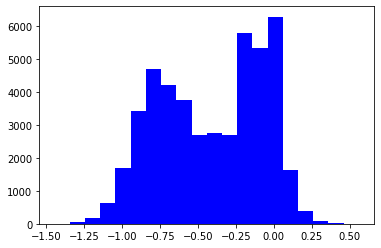

In [22]:
plt.hist(data_df_GE['fitness'],bins=20,color='blue')
plt.show()

In [23]:
gpmapGE = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)
#gpmapGE = mavenn.gpmap.MultilayerPerceptronGPMap(L, alphabet)
mp_GE = mavenn.measurement_process_layers.GlobalEpsistasisMP(K=50,
                                                           monotonic=True,
                                                           ge_heteroskedasticity_order=2,
                                                           ge_noise_model_type='Gaussian')

In [24]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train_GE, x_test_GE, y_train_GE, y_test_GE = train_test_split(data_df_GE['aa_seq'].values, 
                                                                data_df_GE['fitness'].values, test_size=0.1)

In [25]:
model_GE = mavenn.Model2(gpmap=gpmapGE,
                      mp_list=[mp_GE])

# Set training data
model_GE.set_data(x=x_train_GE,
               #y_list=[data_df['y'].values.reshape(-1,1)],
               y_list=[y_train_GE.reshape(-1,1)],
               shuffle=False)

N = 41,749 observations set as training data.
Using 20.1% for validation.
Time to set data: 1.37 sec.


In [26]:
# Fit model to data
history = model_GE.fit(learning_rate=.0005,
                    epochs=150,
                    batch_size=300,
                    try_tqdm=False,
                    early_stopping=False,
                    early_stopping_patience=5,
                    linear_initialization=False)

Epoch 1/150
112/112 [==============================] - 1s 5ms/step - loss: 304.0646 - I_var: -1.2532 - val_loss: 258.9188 - val_I_var: -1.0366
Epoch 2/150
112/112 [==============================] - 0s 3ms/step - loss: 244.8524 - I_var: -0.9695 - val_loss: 229.8357 - val_I_var: -0.8967
Epoch 3/150
112/112 [==============================] - 0s 3ms/step - loss: 217.6777 - I_var: -0.8383 - val_loss: 204.2489 - val_I_var: -0.7736
Epoch 4/150
112/112 [==============================] - 0s 3ms/step - loss: 193.3647 - I_var: -0.7218 - val_loss: 180.5736 - val_I_var: -0.6597
Epoch 5/150
112/112 [==============================] - 0s 4ms/step - loss: 168.6138 - I_var: -0.6020 - val_loss: 153.3159 - val_I_var: -0.5286
Epoch 6/150
112/112 [==============================] - 0s 3ms/step - loss: 137.4842 - I_var: -0.4522 - val_loss: 119.0497 - val_I_var: -0.3637
Epoch 7/150
112/112 [==============================] - 0s 3ms/step - loss: 101.9894 - I_var: -0.2819 - val_loss: 85.1762 - val_I_var: -0.2007


112/112 [==============================] - 0s 3ms/step - loss: -178.6965 - I_var: 1.0693 - val_loss: -161.8324 - val_I_var: 0.9877
Epoch 59/150
112/112 [==============================] - 0s 3ms/step - loss: -178.9845 - I_var: 1.0712 - val_loss: -164.0636 - val_I_var: 0.9984
Epoch 60/150
112/112 [==============================] - 0s 3ms/step - loss: -179.5908 - I_var: 1.0742 - val_loss: -165.0737 - val_I_var: 1.0033
Epoch 61/150
112/112 [==============================] - 0s 3ms/step - loss: -180.0984 - I_var: 1.0735 - val_loss: -164.0193 - val_I_var: 0.9982
Epoch 62/150
112/112 [==============================] - 0s 3ms/step - loss: -180.2267 - I_var: 1.0763 - val_loss: -164.5280 - val_I_var: 1.0007
Epoch 63/150
112/112 [==============================] - 0s 3ms/step - loss: -180.5252 - I_var: 1.0770 - val_loss: -164.3291 - val_I_var: 0.9997
Epoch 64/150
112/112 [==============================] - 0s 3ms/step - loss: -180.2932 - I_var: 1.0763 - val_loss: -164.9498 - val_I_var: 1.0027
Epoch

Epoch 115/150
112/112 [==============================] - 0s 3ms/step - loss: -184.5948 - I_var: 1.1001 - val_loss: -163.9373 - val_I_var: 0.9979
Epoch 116/150
112/112 [==============================] - 0s 3ms/step - loss: -183.8319 - I_var: 1.0932 - val_loss: -166.4156 - val_I_var: 1.0099
Epoch 117/150
112/112 [==============================] - 0s 3ms/step - loss: -184.6742 - I_var: 1.0992 - val_loss: -164.5464 - val_I_var: 1.0009
Epoch 118/150
112/112 [==============================] - 0s 3ms/step - loss: -183.5719 - I_var: 1.0951 - val_loss: -166.0999 - val_I_var: 1.0083
Epoch 119/150
112/112 [==============================] - 0s 3ms/step - loss: -184.5505 - I_var: 1.0995 - val_loss: -166.7637 - val_I_var: 1.0115
Epoch 120/150
112/112 [==============================] - 0s 3ms/step - loss: -184.5608 - I_var: 1.0984 - val_loss: -166.0638 - val_I_var: 1.0082
Epoch 121/150
112/112 [==============================] - 0s 3ms/step - loss: -184.8980 - I_var: 1.0938 - val_loss: -166.7396 - val

On test data:


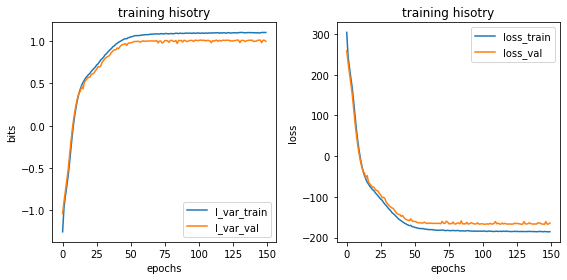

In [27]:
# Show training history
print('On test data:')
# x_test = test_df['x'].values
# y_test = test_df[y_cols].values


I_var_hist = model_GE.history['I_var']
val_I_var_hist = model_GE.history['val_I_var']

fig, axs = plt.subplots(1,2,figsize=[8,4])

ax = axs[0]
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
#ax.set_xscale('log')
ax.set_title('training hisotry')

ax = axs[1]
ax.plot(model_GE.history['loss'], label='loss_train')
ax.plot(model_GE.history['val_loss'], label='loss_val')
# ax.set_xlim(100,300)
# ax.set_ylim(0.7*1e6,0.8*1e6)
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_title('training hisotry')
fig.tight_layout()

In [28]:
phi = gpmapGE.x_to_phi(x_test_GE)
phi_train = gpmapGE.x_to_phi(x_train_GE)

In [29]:
model_GE.model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence_labels_input (InputLa  [(None, 1198)]      0           []                               
 yer)                                                                                             
                                                                                                  
 Sequence_only (Lambda)         (None, 1197)         0           ['Sequence_labels_input[0][0]']  
                                                                                                  
 additive_gp_map_layer (Additiv  (None, 1)           1198        ['Sequence_only[0][0]']          
 eGPMapLayer)                                                                                     
                                                                                            

In [30]:
np.corrcoef(phi_train,y_train_GE)[0,1]**2

0.7866531276975911

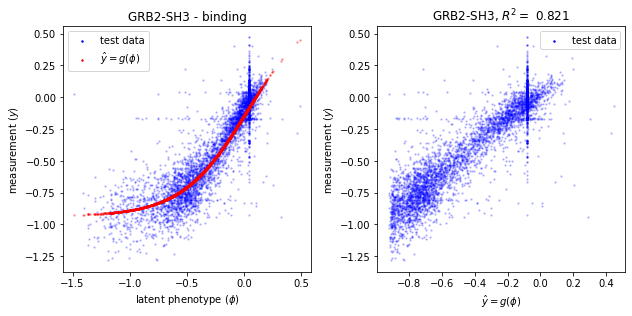

In [31]:
fig, axs = plt.subplots(1,2, figsize=(9,4.5))

ax = axs[0]
yhat = mp_GE.phi_to_yhat(phi)
ax.scatter(phi,y_test_GE,s=2,alpha=0.2,c='b',label='test data')
#ax.scatter(phi,yhat* model.y_std+model.y_mean,s=1,alpha=0.1,c='r',label='$\hat{y} = g(\phi)$')
ax.scatter(phi,yhat,s=2,alpha=0.3,c='r',label='$\hat{y} = g(\phi)$')

ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('GRB2-SH3 - binding')
leg = ax.legend()

for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
    
ax = axs[1]
ax.scatter(yhat,y_test_GE,s=2,alpha=0.2,c='b',label='test data')
Rsq = np.corrcoef(yhat.numpy().ravel(),y_test_GE)[0,1]**2

ax.set_xlabel('$\hat{y} = g(\phi)$')
ax.set_ylabel('measurement ($y$)')
ax.set_title(f'GRB2-SH3, $R^2 = $ {Rsq:.3f}')
leg = ax.legend()

for lh in leg.legendHandles: 
    lh.set_alpha(1)

fig.tight_layout()
#fig.savefig('plots/GRB2_SH3/global_epistasis_binding_binding.png',dpi=300,bbox_inches='tight')    


In [32]:
theta_lc_GE = gpmapGE.get_theta(model_GE,gauge='consensus')['theta_lc']

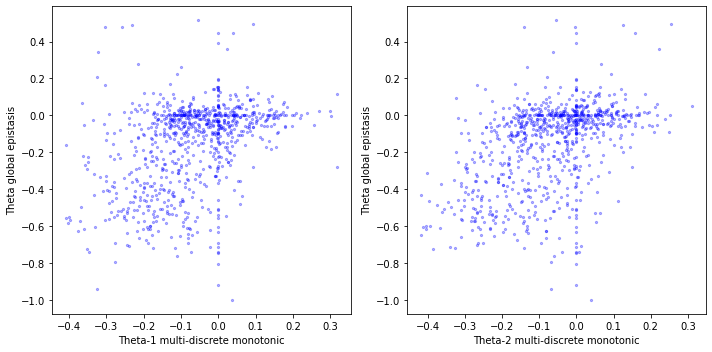

In [33]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(theta_2_lc[0].ravel(),theta_lc_GE.ravel(),c='blue',s=5,alpha=0.3)
ax[0].set_xlabel('Theta-1 multi-discrete monotonic')
ax[0].set_ylabel('Theta global epistasis')

ax[1].scatter(theta_2_lc[1].ravel(),theta_lc_GE.ravel(),c='blue',s=5,alpha=0.3)
ax[1].set_xlabel('Theta-2 multi-discrete monotonic')
ax[1].set_ylabel('Theta global epistasis')

fig.tight_layout()

In [34]:
lehner_binding_singles_df = pd.read_csv('data/GRB2-SH3.singles_binding.csv',index_col=[0])
lehner_binding_singles_df

,Pos,WT_AA,Mut,nt_seq,aa_seq,Nham_nt,Nham_aa,Nmut_codons,STOP,STOP_readthrough,mean_count,fitness,sigma
1,1,T,K,NaN,KYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,2181.666667,0.010464,0.005995
2,1,T,N,NaN,NYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,16.000000,0.028944,0.087284
3,2,Y,K,NaN,TKVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,23.000000,-0.093964,0.092442
4,2,Y,N,NaN,TNVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,8892.666667,-0.035080,0.004516
5,2,Y,S,NaN,TSVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,54.666667,0.044625,0.027825
...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,1,T,A,NaN,AYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,11058.666667,-0.013506,0.004341
708,1,T,G,NaN,GYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,14.000000,-0.012349,0.071471
709,1,T,V,NaN,VYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,57.000000,-0.002641,0.028864
710,1,T,*,NaN,*YVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,True,False,15.000000,-0.219692,0.074135


In [35]:
binding_singles_transformed_df = pd.DataFrame(np.nan*np.ones(shape=(57,21)),columns=alphabet)
binding_singles_transformed_df.head()

,A,C,D,E,F,G,H,I,K,L,...,N,P,Q,R,S,T,V,W,Y,*
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
for idx in lehner_binding_singles_df.index:

    mutant = lehner_binding_singles_df.loc[idx]['Mut']
    value = lehner_binding_singles_df.loc[idx]['fitness']
    
    pos = lehner_binding_singles_df.loc[idx]['Pos']-1
    binding_singles_transformed_df[mutant][pos] = value

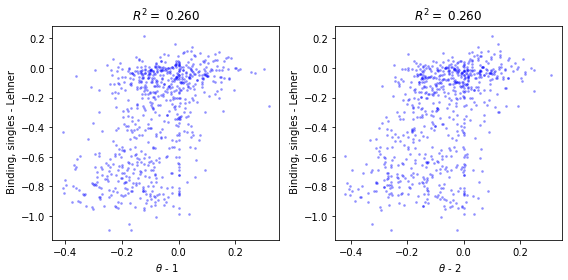

In [37]:
fig, axs = plt.subplots(1,2,figsize=(8,4))

ax = axs[0]
Rsq = np.corrcoef(theta_2_lc[0].ravel(),binding_singles_transformed_df.fillna(0).values.ravel())[0,1]**2
ax.scatter(theta_2_lc[0].ravel(),binding_singles_transformed_df.values.ravel(),s=3,alpha=0.3,color='blue')
ax.set_xlabel(' $\\theta$ - 1')
ax.set_ylabel(' Binding, singles - Lehner')
ax.set_title(f'$R^2 = $ {Rsq:.3f}')

ax = axs[1]
Rsq = np.corrcoef(theta_2_lc[1].ravel(),binding_singles_transformed_df.fillna(0).values.ravel())[0,1]**2
ax.scatter(theta_2_lc[1].ravel(),binding_singles_transformed_df.values.ravel(),s=3,alpha=0.3,color='blue')
ax.set_xlabel(' $\\theta$ - 2')
ax.set_ylabel(' Binding, singles - Lehner')
ax.set_title(f'$R^2 = $ {Rsq:.3f}')

fig.tight_layout()

#fig.savefig('plots/GRB2_SH3/GRB2_SH3.singles_binding_comparison_to_Lehner.png',dpi=200,bbox_inches='tight')


Text(0.5, 1.0, 'Lehner - binding')

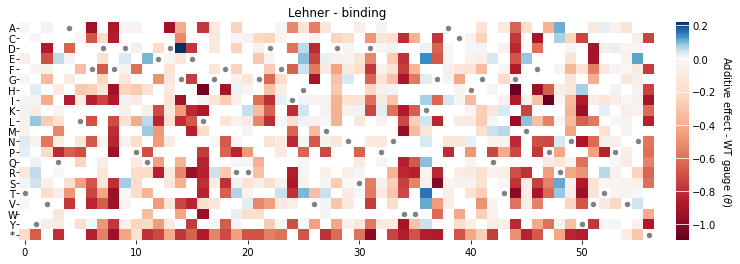

In [38]:
# # Create fig and ax objects
fig, ax = plt.subplots(figsize=[12,4])

# Draw heatmap
ax, cb = mavenn.heatmap(ax=ax,
                        values=binding_singles_transformed_df.values,
                        alphabet=alphabet,
                        seq=model.x_stats['consensus_seq'],
                        seq_kwargs={'c':'gray', 's':20,'marker':'o'},
                        cmap='RdBu',
                        cbar=True,
                        #clim = [-5,1],
                        cmap_size='2%',
                        cmap_pad=.3,
                        ccenter=0)

# Style colorbar
cb.set_label('Additive effect - WT gauge ($\\theta$)',
             labelpad=10, ha='center', va='center', rotation=-90)
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
ax.set_title('Lehner - binding')

#fig.savefig('plots/GRB2_SH3/Lehner_GP_map_binding.png',dpi=300,bbox_inches='tight')